In [1]:
library(rstan)
library(brms)

rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())

Loading required package: StanHeaders
Loading required package: ggplot2
rstan (Version 2.19.2, GitRev: 2e1f913d3ca3)
For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
Loading required package: Rcpp
Loading 'brms' package (version 2.9.0). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').

Attaching package: ‘brms’

The following object is masked from ‘package:rstan’:

    loo



In [2]:
fish_num_climate_2  <- read.csv("https://raw.githubusercontent.com/logics-of-blue/book-r-stan-bayesian-model-intro/master/book-data/4-1-1-fish-num-2.csv")
head(fish_num_climate_2)

fish_num,weather,temperature,id
<int>,<fct>,<dbl>,<int>
0,cloudy,5.0,1
1,cloudy,24.2,2
6,cloudy,11.5,3
0,cloudy,9.8,4
1,cloudy,18.1,5
1,cloudy,18.1,6


In [3]:
summary(fish_num_climate_2)

    fish_num       weather    temperature           id        
 Min.   : 0.00   cloudy:50   Min.   : 0.300   Min.   :  1.00  
 1st Qu.: 0.00   sunny :50   1st Qu.: 6.875   1st Qu.: 25.75  
 Median : 1.00               Median :14.450   Median : 50.50  
 Mean   : 2.66               Mean   :14.517   Mean   : 50.50  
 3rd Qu.: 4.00               3rd Qu.:23.025   3rd Qu.: 75.25  
 Max.   :15.00               Max.   :29.800   Max.   :100.00  

In [4]:
fish_num_climate_2$id <- as.factor(fish_num_climate_2$id)

In [5]:
head(fish_num_climate_2)

fish_num,weather,temperature,id
<int>,<fct>,<dbl>,<fct>
0,cloudy,5.0,1
1,cloudy,24.2,2
6,cloudy,11.5,3
0,cloudy,9.8,4
1,cloudy,18.1,5
1,cloudy,18.1,6


Compiling the C++ model
Start sampling


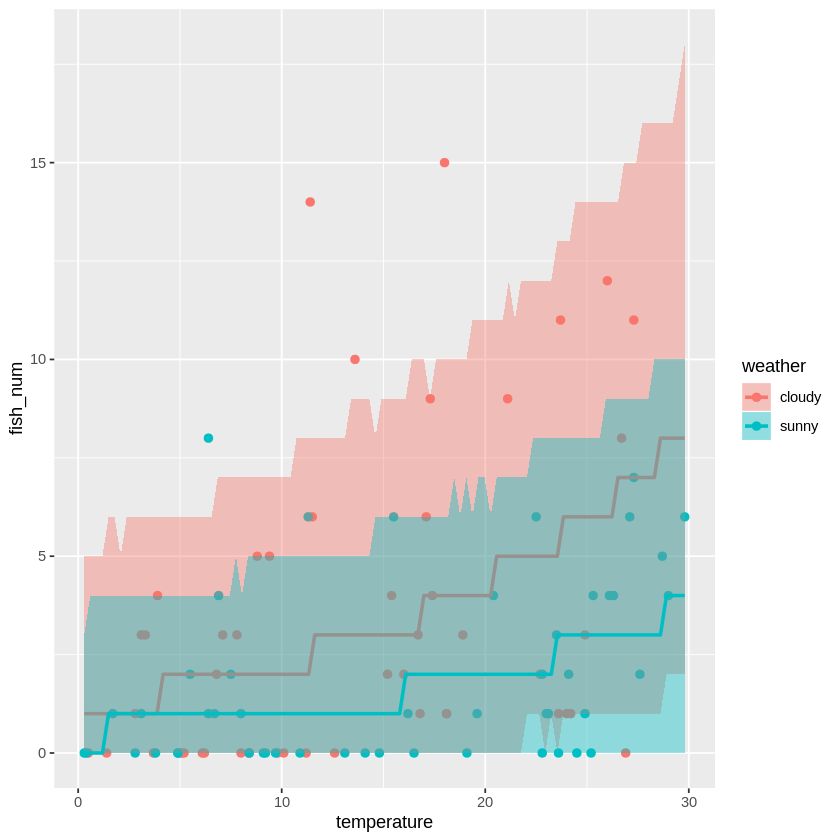

In [6]:
glm_pois_brms <- brm(
    formula = fish_num ~ weather + temperature,
    family = poisson(),
    data = fish_num_climate_2,
    seed = 1,
    prior = c(set_prior("", class = "Intercept"))
)
set.seed(1)

eff_glm_pre <- marginal_effects(
    glm_pois_brms,
    method = "predict",
    effects = "temperature:weather",
    probs = c(0.005, 0.995)
)

plot(eff_glm_pre, points = T)

In [12]:
formula_pois <- formula(fish_num ~ weather + temperature)
design_mat <- model.matrix(formula_pois, fish_num_climate_2)
sunny_dummy <- as.numeric(design_mat[, "weathersunny"])

data_list_1 <- list(
    N = nrow(fish_num_climate_2),
    fish_num = fish_num_climate_2$fish_num,
    temp = fish_num_climate_2$temperature,
    sunny = sunny_dummy
)

data_list_1

$N
[1] 100

$fish_num
  [1]  0  1  6  0  1  1  0  5  9  3  4  2  2  3 12  3  3  9  0  0  2  0  4  1  3
 [26] 11 15 11  1  2 14  0  0 10  3  0  8  0  4  0  0  1  0  6  0  0  0  3  5  1
 [51]  4  1  4  6  4  7  0  1  0  0  0  1  2  1  1  0  1  1  0  0  0  2  6  4  6
 [76]  0  0  0  0  6  3  1  6  0  5  0  8  0  0  2  0  1  0  1  4  2  0  0  2  4

$temp
  [1]  5.0 24.2 11.5  9.8 18.1 18.1  3.7  8.8 17.3 18.9 15.4 15.2 16.0 16.7 26.0
 [16] 24.9  3.3 21.1 26.9  8.4  6.8  0.5  3.9  2.8  7.1 23.7 18.0 27.3 16.8 22.7
 [31] 11.4 11.2  5.1 13.6  7.8 10.1 26.7  6.1 17.4  6.2  8.4 23.6  5.2 17.1 12.6
 [46]  8.0  1.4  3.1  9.4 24.0  6.9  6.4 26.3 29.8 25.3 27.3 14.1  6.7  3.8  8.4
 [61] 24.5  1.7 24.1  3.1 23.0  9.1 23.1 16.2 10.9  2.8 22.8 22.8 27.1 29.0 15.5
 [76] 16.5  4.9  4.9 23.6 22.5 23.5 19.6 11.3  0.3 28.7 25.2  6.4 14.8 19.1 27.6
 [91]  0.4  8.0 13.1 24.9 26.1  7.5  9.7  9.2  5.5 20.4

$sunny
  [1] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [38] 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [75] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

In [15]:
glmm_pois_stan <- stan(
    file = "4-1-1-glmm-pois.stan",
    data = data_list_1,
    seed = 1
)

In [16]:
rhat(glmm_pois_stan)

Intercept      b_temp     b_sunny        r[1]        r[2]        r[3] 
  1.0014750   1.0022879   1.0013401   0.9994084   0.9993430   1.0010539 
       r[4]        r[5]        r[6]        r[7]        r[8]        r[9] 
  0.9991882   0.9999847   0.9998384   0.9992308   1.0009738   1.0001002 
      r[10]       r[11]       r[12]       r[13]       r[14]       r[15] 
  1.0007193   0.9999015   0.9998991   0.9993711   0.9993761   1.0019678 
      r[16]       r[17]       r[18]       r[19]       r[20]       r[21] 
  1.0015002   0.9996214   1.0004234   1.0007364   1.0002495   1.0001069 
      r[22]       r[23]       r[24]       r[25]       r[26]       r[27] 
  0.9991402   1.0016010   1.0005271   0.9997804   1.0001836   1.0013200 
      r[28]       r[29]       r[30]       r[31]       r[32]       r[33] 
  1.0004503   1.0000298   0.9999660   1.0014105   1.0003071   0.9997644 
      r[34]       r[35]       r[36]       r[37]       r[38]       r[39] 
  0.9996921   0.9998123   0.9996882   1.0016942   1.0002937   1.0003442 
      r[40]       r[41]       r[42]       r[43]       r[44]       r[45] 
  1.0003568   0.9992185   0.9995245   0.9994162   1.0004508   1.0000624 
      r[46]       r[47]       r[48]       r[49]       r[50]       r[51] 
  0.9992054   1.0002774   1.0005055   1.0008569   0.9996202   1.0000309 
      r[52]       r[53]       r[54]       r[55]       r[56]       r[57] 
  0.9999068   0.9999834   1.0000918   0.9995216   0.9996069   0.9998692 
      r[58]       r[59]       r[60]       r[61]       r[62]       r[63] 
  0.9992531   0.9997935   1.0000115   0.9998641   0.9996557   0.9997669 
      r[64]       r[65]       r[66]       r[67]       r[68]       r[69] 
  1.0003824   1.0000229   0.9996101   0.9999776   0.9995553   0.9993957 
      r[70]       r[71]       r[72]       r[73]       r[74]       r[75] 
  1.0000483   0.9996654   0.9992320   0.9995787   0.9997853   1.0007736 
      r[76]       r[77]       r[78]       r[79]       r[80]       r[81] 
  0.9996718   1.0000897   0.9994422   1.0001545   1.0008681   1.0000246 
      r[82]       r[83]       r[84]       r[85]       r[86]       r[87] 
  0.9995660   1.0008718   1.0003356   1.0001604   0.9998086   1.0013955 
      r[88]       r[89]       r[90]       r[91]       r[92]       r[93] 
  1.0000200   0.9993141   1.0008030   0.9997949   0.9992460   0.9994868 
      r[94]       r[95]       r[96]       r[97]       r[98]       r[99] 
  0.9992463   1.0003849   0.9994814   0.9998378   1.0002435   0.9995102 
     r[100]     sigma_r   lambda[1]   lambda[2]   lambda[3]   lambda[4] 
  0.9999757   1.0020563   0.9994268   0.9991422   0.9997467   0.9993173 
  lambda[5]   lambda[6]   lambda[7]   lambda[8]   lambda[9]  lambda[10] 
  1.0003125   0.9996632   0.9992622   0.9997669   0.9996452   0.9995620 
 lambda[11]  lambda[12]  lambda[13]  lambda[14]  lambda[15]  lambda[16] 
  0.9994931   0.9993759   0.9995831   0.9992142   0.9997000   1.0005217 
 lambda[17]  lambda[18]  lambda[19]  lambda[20]  lambda[21]  lambda[22] 
  0.9991593   0.9993965   1.0003139   1.0009298   0.9998387   0.9994970 
 lambda[23]  lambda[24]  lambda[25]  lambda[26]  lambda[27]  lambda[28] 
  1.0006895   1.0000287   0.9994432   0.9994094   0.9999438   0.9992983 
 lambda[29]  lambda[30]  lambda[31]  lambda[32]  lambda[33]  lambda[34] 
  0.9995513   1.0000913   0.9999611   1.0005604   1.0003998   0.9993187 
 lambda[35]  lambda[36]  lambda[37]  lambda[38]  lambda[39]  lambda[40] 
  0.9993773   0.9994542   1.0000225   1.0007668   1.0009012   1.0010323 
 lambda[41]  lambda[42]  lambda[43]  lambda[44]  lambda[45]  lambda[46] 
  0.9993069   0.9997752   0.9994343   0.9995133   1.0005790   0.9992174 
 lambda[47]  lambda[48]  lambda[49]  lambda[50]  lambda[51]  lambda[52] 
  1.0004905   1.0000599   1.0000865   0.9993321   0.9993964   0.9995742 
 lambda[53]  lambda[54]  lambda[55]  lambda[56]  lambda[57]  lambda[58] 
  0.9994630   0.9993329   0.9995466   0.9994403   1.0001977   0.9993341 
 lambda[59]  lambda[60]  lambda[61]  lambda[62]  lambda[63] 

This is bayesplot version 1.7.0
- Online documentation and vignettes at mc-stan.org/bayesplot
- bayesplot theme set to bayesplot::theme_default()
   * Does _not_ affect other ggplot2 plots
   * See ?bayesplot_theme_set for details on theme setting


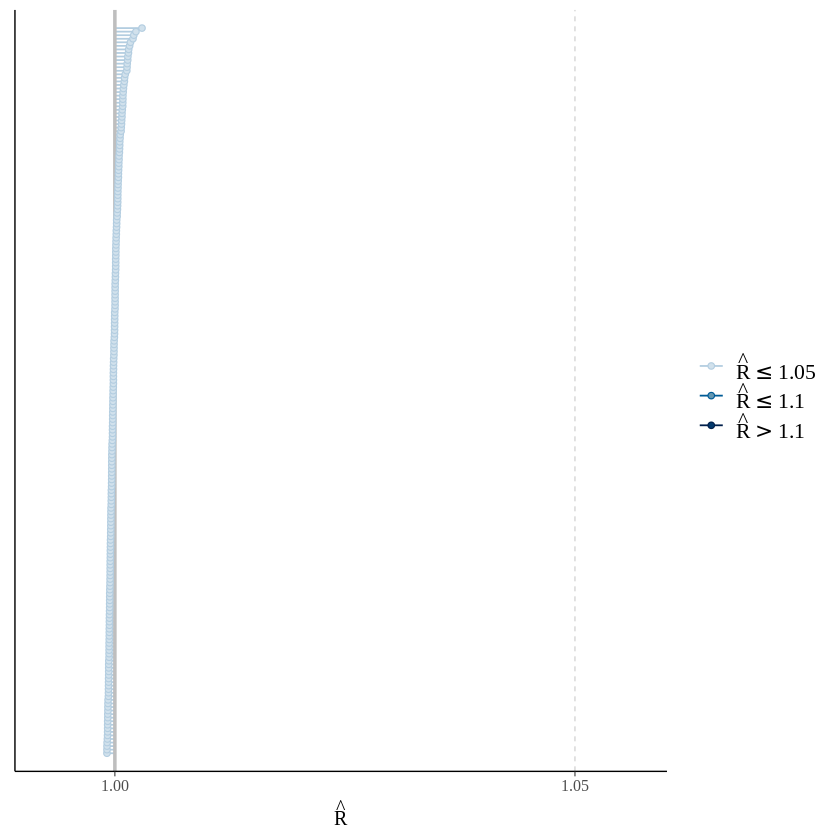

In [19]:
library(bayesplot)
mcmc_rhat(rhat(glmm_pois_stan))

In [17]:
glmm_pois_brms <- brm(
    formula = fish_num ~ weather + temperature + (1|id),
    family = poisson(),
    data = fish_num_climate_2,
    seed = 1,
    prior = c(set_prior("", class = "Intercept"), set_prior("", class = "sd"))
)

Compiling the C++ model
Start sampling


In [18]:
glmm_pois_brms

 Family: poisson 
  Links: mu = log 
Formula: fish_num ~ weather + temperature + (1 | id) 
   Data: fish_num_climate_2 (Number of observations: 100) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup samples = 4000

Group-Level Effects: 
~id (Number of levels: 100) 
              Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sd(Intercept)     1.10      0.16     0.83     1.44       1120 1.00

Population-Level Effects: 
             Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
Intercept       -0.46      0.34    -1.18     0.16       1472 1.00
weathersunny    -0.73      0.29    -1.28    -0.16       1112 1.00
temperature      0.08      0.02     0.04     0.11       1186 1.00

Samples were drawn using sampling(NUTS). For each parameter, Eff.Sample 
is a crude measure of effective sample size, and Rhat is the potential 
scale reduction factor on split chains (at convergence, Rhat = 1).